<a href="https://colab.research.google.com/github/TailUFPB/fundos-imobiliarios/blob/main/Rankeamento_Modelo_FIIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rankeamento de fundos e modelo de classificação

In [1]:
#Imports
import pandas as pd
import numpy as np
!pip install pycaret
from pycaret.classification import *
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

     |████████████████████████████████| 263 kB 6.3 MB/s 
     |████████████████████████████████| 271 kB 49.5 MB/s 
     |████████████████████████████████| 56 kB 3.2 MB/s 
     |████████████████████████████████| 105 kB 45.7 MB/s 
     |████████████████████████████████| 167 kB 52.2 MB/s 
     |████████████████████████████████| 248 kB 40.6 MB/s 
     |████████████████████████████████| 6.8 MB 46.7 MB/s 
     |████████████████████████████████| 1.7 MB 25.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 24.0 MB/s 
     |████████████████████████████████| 80 kB 8.2 MB/s 
     |████████████████████████████████| 1.3 MB 30.6 MB/s 
     |████████████████████████████████| 14.4 MB 58 kB/s 
     |████████████████████████████████| 102 kB 50.5 MB/s 
     |████████████████████████████████| 10.1 MB 46.4 MB/s 
     |██████████████████

## Rankeamento dos fundos:

Para fazermos o rankeamento dos fundos, a fim de descobrir quais são os melhores no mercado brasileiro, escolhemos a estratégia de atribuir uma nota para cada um deles, que levará em consideração tanto os atributos atuais de cada um, como sua performance ao longo dos anos.



---


Primeiramente, vamos pegar o CSV com atributos atuais dos fundos, que ficará na variável df, e os CSVs com atributos históricos, que ficarão na lista dfs_old:

In [2]:
#Recebendo o CSV dos fundos

url = 'https://raw.githubusercontent.com/TailUFPB/fundos-imobiliarios/main/CSV_Modelo.csv'
data = pd.read_csv(url)
df = pd.DataFrame(data)

In [3]:
datas = ['202012', '202009', '202003', '201902', '201812', '201809', '201806', '201803', '201712']
dfs_old = []

for i in datas:
  url = 'https://raw.githubusercontent.com/TailUFPB/fundos-imobiliarios/main/CSV_Antigos_PreProc/' + i + '.csv'
  data = pd.read_csv(url)
  dfs_old.append(pd.DataFrame(data))

In [4]:
pd.set_option("display.max_rows", None)



---


Agora, vamos definir as funções que iremos utilizar para obter a nota de cada fundo:

Na função *NotaInicial*, iremos usar alguns atributos do fundo para dar uma nota inicial a ele, e faremos isso subtraindo o valor de alguns campos de cada fundo com a média de todos no dataset, e multiplicando o valor por um peso dado a cada atributo baseado na sua importância para a avaliação do fundo, ou seja, se o peso do campo for positivo, quanto maior for o valor do atributo, melhor nota obterá, e caso seja negativo, o contrário. 

In [5]:
#Dando notas para colunas que não tem delimitador definido (Quanto mais alto ou mais baixo, melhor)
def NotaInicial(df):
  pesos = {'Variação Preço': 0.6, 'Rentab.Período': 0.3, 'PatrimônioLíq.': 0.15,'Liquidez Diária': 0.7,'Rentab.Acumulada': 0.75, 'VPA': 0.25,'QuantidadeAtivos': 0.45, 'VacânciaFísica': -0.65}
  colunas = ['Liquidez Diária' , 'Variação Preço','Rentab.Período','Rentab.Acumulada', 'PatrimônioLíq.', 'VPA','QuantidadeAtivos', 'VacânciaFísica']

  i = 0
  notas = []

  while i < df.shape[0]:

    nota_row = 0
    for j in colunas:
      if j in df.columns:
        nota_row += pesos[j] * (df.loc[i, j] - df[j].mean())
    
    notas.append(nota_row)

    i += 1

  df['Notas'] = notas

  return df

A função *PVPA* funciona de forma parecida, porém ao invés de comparar o atributo com a média do dataset, compara com um valor ideal, multiplica pelo peso e se subtrai da nota total, ou seja, quanto mais perto do valor ideal, melhor para o fundo.

In [6]:
#Dando notas para colunas que tem delimitador definido (Quanto mais perto do valor ideal, melhor)
def PVPA(df):
  pesos2 = {'P/VPA': 0.7}
  ideal_value = {'P/VPA': 0.67346938}
  colunas = ['P/VPA']

  for i in range(df.shape[0]):

    for j in colunas:
      df.loc[i, 'Notas'] -= pesos2[j] * abs(df.loc[i, j] - ideal_value[j])

  return df

Para obter a nota do fundo no momento atual dele, a última função que vamos usar é a *DividendAnalysis*, que dividirá o dataset em quartis baseados na sua performance nos campos relacionados a Dividend Yield, e multiplicando o valor dado a cada quartil por um peso de cada atributo, (de quanto mais tempo for a média do yield, maior o peso) será obtido um resultado, que será somado à nota do campo.

In [7]:
def DividendAnalysis(df):
  d = df["DividendYield"].describe()
  d_3 = df["DY (3M)Média"].describe()
  d_6 = df["DY (6M)Média"].describe()
  d_12 = df["DY (12M)Média"].describe()

  for column in ["DividendYield", "DY (3M)Média", "DY (6M)Média", "DY (12M)Média"]:

    if column == "DividendYield":
      x = 1/22
    elif column == "DY (3M)Média":
      x = 3/22
    elif column == "DY (6M)Média":
      x = 6/22
    else:
      x = 12/22

    for i in range(df.shape[0]):
      if df[column].iloc[i] < df[column].describe()["25%"]:
        df.loc[i, 'Notas'] += 0*x
      elif df[column].iloc[i] >= df[column].describe()["25%"] and df[column].iloc[i] < df[column].describe()["50%"]:
        df.loc[i, 'Notas'] += 0.4*x
      elif df[column].iloc[i] >= df[column].describe()["50%"] and df[column].iloc[i] < df[column].describe()["75%"]:
        df.loc[i, 'Notas'] += 0.8*x
      elif df[column].iloc[i] >= df[column].describe()["75%"]:
        df.loc[i, 'Notas'] += 1.25*x
  
  return df

Por fim, para obtermos uma análise mais completa, vamos levar em consideração também a performance histórica de cada fundo, somando-se à nota original do fundo a que ele obteve no passado, após mutiplicá-la por um peso, que é menor quanto mais distante estiver do momento atual.

In [8]:
def AdaptarNota(df, old_dfs):
  pesos_data = {'202012': 1/3, '202009': 1/6, '202003': 1/12, '201912': 1/15, '201902': 1/24, '201812': 1/26, '201809': 1/29, '201806': 1/32, '201803': 1/35, '201712': 1/38}

  for index, row in df.iterrows():
    
    df_fundo = old_dfs.loc[old_dfs['Códigodo fundo'] == df.loc[index, 'Códigodo fundo'], ['Notas', 'Ano/Mês']]

    if df_fundo.empty:
      continue
  
    for index_old, row_old in df_fundo.iterrows():
      df.loc[index, 'Notas'] += df_fundo.loc[index_old, 'Notas'] * pesos_data[str(df_fundo.loc[index_old, 'Ano/Mês'])]

  return df

Com as funções definidas, podemos começar nossa análise aplicando as três funções iniciais ao nosso dataset:

In [9]:
df = NotaInicial(df)
df = PVPA(df)
df = DividendAnalysis(df)

E também aos datasets do passado:

In [10]:
for i in range(len(dfs_old)):
  dfs_old[i].drop('Unnamed: 0', axis='columns', inplace=True)
  dfs_old[i] = NotaInicial(dfs_old[i])
  dfs_old[i] = PVPA(dfs_old[i])
  dfs_old[i] = DividendAnalysis(dfs_old[i])

Depois, concatenamos todos os datasets do passado em um só, e chamamos a função *AdaptarNota*, assim, obtendo a nota final de cada fundo imobiliário:

In [11]:
dfs_old = pd.concat(dfs_old)
dfs_old.reset_index(drop=True, inplace=True)
df = AdaptarNota(df, dfs_old)

E ficamos com o seguinte rankeamento dos fundos:

In [12]:
df_sort = df.sort_values('Notas', ascending=False)
df_sort.reset_index(drop=True, inplace=True)
df_sort = df_sort[['Códigodo fundo', 'Setor', 'Preço Atual', 'Notas']]

In [13]:
df_sort

,Códigodo fundo,Setor,Preço Atual,Notas
0,BBPO11,Lajes Corporativas,114.10,2.642532
1,IRDM11,Títulos e Val. Mob.,131.39,2.419633
2,RECR11,Títulos e Val. Mob.,101.55,2.412386
3,CPTS11,Títulos e Val. Mob.,99.60,2.358630
4,HABT11,Títulos e Val. Mob.,124.66,2.161607
5,TGAR11,Outros,137.13,2.157821
6,BBRC11,Outros,116.00,2.116562
7,BNFS11,Outros,123.60,2.109137
8,BARI11,Títulos e Val. Mob.,106.70,2.048882
9,BCRI11,Títulos e Val. Mob.,112.25,2.020643


## Modelo de classificação de fundos

Agora, podemos também fazer um modelo de Machine Learning que, com os dados de um fundo em mãos, possa classificá-lo em: bom, médio ou ruim.

Para fazer isso, primeiro vamos utilizar os datasets que já temos para treinar o modelo:

In [27]:
dfs_modelo = []
url = 'https://raw.githubusercontent.com/TailUFPB/fundos-imobiliarios/main/CSV_Modelo.csv'
data = pd.read_csv(url)
dfs_modelo.append(pd.DataFrame(data))
datas = ['202012', '202009', '202003', '201902']

for i in datas:
  url = 'https://raw.githubusercontent.com/TailUFPB/fundos-imobiliarios/main/CSV_Antigos_PreProc/' + i + '.csv'
  data = pd.read_csv(url)
  dfs_modelo.append(pd.DataFrame(data))

dfs_modelo[0].drop(['Unnamed: 0', 'Ano/Mês','Setor', 'Preço Atual', 'Dividendo', 'DY Ano'], axis='columns', inplace=True)
for i in range(1,len(dfs_modelo)):
  #Retirando colunas desnecessárias
  dfs_modelo[i].drop(['Unnamed: 0', 'Ano/Mês','Unnamed: 0.1', 'Preço Atual', 'Dividendo', 'DY Ano'], axis='columns', inplace=True)

Agora, vamos dar uma nota para todos os fundos desse nosso dataset, utilizando as funções do começo do notebook:

In [28]:
for i in range(len(dfs_modelo)):
  dfs_modelo[i] = NotaInicial(dfs_modelo[i])
  dfs_modelo[i] = PVPA(dfs_modelo[i])
  dfs_modelo[i] = DividendAnalysis(dfs_modelo[i])

dfs_modelo = pd.concat(dfs_modelo)

dfs_modelo = dfs_modelo.sort_values('Notas', ascending=False)
dfs_modelo.reset_index(drop=True, inplace=True)

Levando em consideração a nota obtida de cada modelo, podemos separá-los nas 3 categorias em que queremos classificar:

In [34]:
dfs_modelo['Label'] = ''
for index, row in dfs_modelo.iterrows():
  if dfs_modelo.loc[index, 'Notas'] <= 0:
    dfs_modelo.loc[index,'Label'] = 'Ruim'
  elif dfs_modelo.loc[index, 'Notas'] <= 0.85:
    dfs_modelo.loc[index,'Label'] = 'Médio'
  else:
    dfs_modelo.loc[index,'Label'] = 'Bom'

dfs_modelo.drop(['Notas'], axis='columns', inplace=True)

Agora, podemos utilizar a biblioteca Pycaret para aplicar vários modelos de ML nos nossos dados e descobrir qual o que melhor consegue classificá-los:

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.809,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.3


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.862,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
lr,Logistic Regression,0.809,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300
dt,Decision Tree Classifier,0.7832,0.7883,0.7480,0.7872,0.7788,0.6013,0.6070,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300
svm,SVM - Linear Kernel,0.7961,0.0000,0.7396,0.8187,0.7854,0.6178,0.6415,0.062
dt,Decision Tree Classifier,0.7832,0.7883,0.7480,0.7872,0.7788,0.6013,0.6070,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300
svm,SVM - Linear Kernel,0.7961,0.0000,0.7396,0.8187,0.7854,0.6178,0.6415,0.062
dt,Decision Tree Classifier,0.7832,0.7883,0.7480,0.7872,0.7788,0.6013,0.6070,0.020
ridge,Ridge Classifier,0.7431,0.0000,0.6083,0.7541,0.7172,0.4792,0.5144,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8679,0.9470,0.8246,0.8739,0.8654,0.7561,0.7622,0.518
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300
svm,SVM - Linear Kernel,0.7961,0.0000,0.7396,0.8187,0.7854,0.6178,0.6415,0.062
dt,Decision Tree Classifier,0.7832,0.7883,0.7480,0.7872,0.7788,0.6013,0.6070,0.020
ridge,Ridge Classifier,0.7431,0.0000,0.6083,0.7541,0.7172,0.4792,0.5144,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8679,0.9470,0.8246,0.8739,0.8654,0.7561,0.7622,0.518
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
qda,Quadratic Discriminant Analysis,0.8329,0.9061,0.8255,0.8371,0.8324,0.7038,0.7063,0.018
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300
svm,SVM - Linear Kernel,0.7961,0.0000,0.7396,0.8187,0.7854,0.6178,0.6415,0.062
dt,Decision Tree Classifier,0.7832,0.7883,0.7480,0.7872,0.7788,0.6013,0.6070,0.020
ridge,Ridge Classifier,0.7431,0.0000,0.6083,0.7541,0.7172,0.4792,0.5144,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8679,0.9470,0.8246,0.8739,0.8654,0.7561,0.7622,0.518
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
qda,Quadratic Discriminant Analysis,0.8329,0.9061,0.8255,0.8371,0.8324,0.7038,0.7063,0.018
ada,Ada Boost Classifier,0.8275,0.8808,0.7400,0.8510,0.8158,0.6646,0.6894,0.123
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300
svm,SVM - Linear Kernel,0.7961,0.0000,0.7396,0.8187,0.7854,0.6178,0.6415,0.062
dt,Decision Tree Classifier,0.7832,0.7883,0.7480,0.7872,0.7788,0.6013,0.6070,0.020
ridge,Ridge Classifier,0.7431,0.0000,0.6083,0.7541,0.7172,0.4792,0.5144,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8679,0.9470,0.8246,0.8739,0.8654,0.7561,0.7622,0.518
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
gbc,Gradient Boosting Classifier,0.8566,0.9441,0.8088,0.8688,0.8511,0.7324,0.7465,0.553
qda,Quadratic Discriminant Analysis,0.8329,0.9061,0.8255,0.8371,0.8324,0.7038,0.7063,0.018
ada,Ada Boost Classifier,0.8275,0.8808,0.7400,0.8510,0.8158,0.6646,0.6894,0.123
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300
svm,SVM - Linear Kernel,0.7961,0.0000,0.7396,0.8187,0.7854,0.6178,0.6415,0.062
dt,Decision Tree Classifier,0.7832,0.7883,0.7480,0.7872,0.7788,0.6013,0.6070,0.020
ridge,Ridge Classifier,0.7431,0.0000,0.6083,0.7541,0.7172,0.4792,0.5144,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8679,0.9470,0.8246,0.8739,0.8654,0.7561,0.7622,0.518
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
gbc,Gradient Boosting Classifier,0.8566,0.9441,0.8088,0.8688,0.8511,0.7324,0.7465,0.553
qda,Quadratic Discriminant Analysis,0.8329,0.9061,0.8255,0.8371,0.8324,0.7038,0.7063,0.018
lda,Linear Discriminant Analysis,0.8328,0.9350,0.7669,0.8493,0.8252,0.6795,0.6970,0.018
ada,Ada Boost Classifier,0.8275,0.8808,0.7400,0.8510,0.8158,0.6646,0.6894,0.123
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300
svm,SVM - Linear Kernel,0.7961,0.0000,0.7396,0.8187,0.7854,0.6178,0.6415,0.062
dt,Decision Tree Classifier,0.7832,0.7883,0.7480,0.7872,0.7788,0.6013,0.6070,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8823,0.9580,0.8333,0.8893,0.8787,0.7791,0.7876,0.465
rf,Random Forest Classifier,0.8679,0.9470,0.8246,0.8739,0.8654,0.7561,0.7622,0.518
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
gbc,Gradient Boosting Classifier,0.8566,0.9441,0.8088,0.8688,0.8511,0.7324,0.7465,0.553
qda,Quadratic Discriminant Analysis,0.8329,0.9061,0.8255,0.8371,0.8324,0.7038,0.7063,0.018
lda,Linear Discriminant Analysis,0.8328,0.9350,0.7669,0.8493,0.8252,0.6795,0.6970,0.018
ada,Ada Boost Classifier,0.8275,0.8808,0.7400,0.8510,0.8158,0.6646,0.6894,0.123
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300
svm,SVM - Linear Kernel,0.7961,0.0000,0.7396,0.8187,0.7854,0.6178,0.6415,0.062


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8823,0.9580,0.8333,0.8893,0.8787,0.7791,0.7876,0.465
rf,Random Forest Classifier,0.8679,0.9470,0.8246,0.8739,0.8654,0.7561,0.7622,0.518
lightgbm,Light Gradient Boosting Machine,0.8676,0.9554,0.8255,0.8731,0.8648,0.7554,0.7618,0.232
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
gbc,Gradient Boosting Classifier,0.8566,0.9441,0.8088,0.8688,0.8511,0.7324,0.7465,0.553
qda,Quadratic Discriminant Analysis,0.8329,0.9061,0.8255,0.8371,0.8324,0.7038,0.7063,0.018
lda,Linear Discriminant Analysis,0.8328,0.9350,0.7669,0.8493,0.8252,0.6795,0.6970,0.018
ada,Ada Boost Classifier,0.8275,0.8808,0.7400,0.8510,0.8158,0.6646,0.6894,0.123
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8823,0.9580,0.8333,0.8893,0.8787,0.7791,0.7876,0.465
rf,Random Forest Classifier,0.8679,0.9470,0.8246,0.8739,0.8654,0.7561,0.7622,0.518
lightgbm,Light Gradient Boosting Machine,0.8676,0.9554,0.8255,0.8731,0.8648,0.7554,0.7618,0.232
knn,K Neighbors Classifier,0.8620,0.9220,0.8183,0.8711,0.8588,0.7430,0.7522,0.115
gbc,Gradient Boosting Classifier,0.8566,0.9441,0.8088,0.8688,0.8511,0.7324,0.7465,0.553
qda,Quadratic Discriminant Analysis,0.8329,0.9061,0.8255,0.8371,0.8324,0.7038,0.7063,0.018
lda,Linear Discriminant Analysis,0.8328,0.9350,0.7669,0.8493,0.8252,0.6795,0.6970,0.018
ada,Ada Boost Classifier,0.8275,0.8808,0.7400,0.8510,0.8158,0.6646,0.6894,0.123
nb,Naive Bayes,0.8091,0.9099,0.7958,0.8167,0.8098,0.6629,0.6658,0.017
lr,Logistic Regression,0.8090,0.9346,0.7122,0.8338,0.7965,0.6242,0.6519,0.300


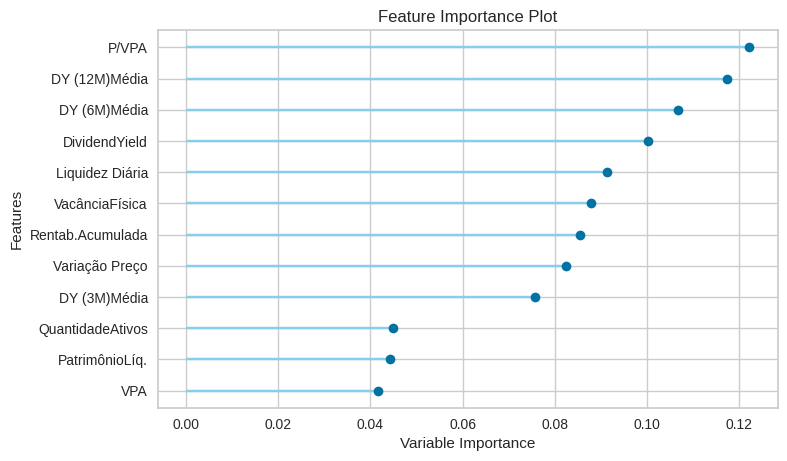

In [35]:
grid = setup(data=dfs_modelo.iloc[:,1:], target='Label', html=False, silent=True, verbose=False)

model = compare_models()
plot_model(model, plot ='feature_all')

Após uma série de testes, concluímos que o melhor modelo é o ExtraTreesClassifier, que ficou com uma acurácia média de 87.5%,então vamos usá-lo:

In [36]:
best_model = tune_model(ExtraTreesClassifier(), n_iter=200)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1806 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  8.5min finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9636,0.9958,0.9674,0.9636,0.9636,0.9357,0.9357
1,0.8909,0.9637,0.8826,0.8943,0.8918,0.8065,0.8069
2,0.8182,0.9372,0.8250,0.8134,0.8144,0.6722,0.6740
3,0.8545,0.9567,0.8264,0.8576,0.8511,0.7312,0.7382
4,0.8909,0.9625,0.8083,0.9081,0.8863,0.7923,0.8098
5,0.9074,0.9673,0.8499,0.9124,0.9054,0.8259,0.8306
6,0.8519,0.9442,0.7961,0.8610,0.8493,0.7262,0.7300
7,0.8519,0.9200,0.7827,0.8549,0.8481,0.7209,0.7280
8,0.8519,0.9254,0.8140,0.8542,0.8512,0.7293,0.7314
9,0.8704,0.9274,0.7798,0.8936,0.8642,0.7460,0.7710


Por fim, podemos testar nosso modelo em funcionamento usando dados dos fundos em uma data que não tínhamos visto antes:

In [41]:
df_teste = pd.read_csv('https://raw.githubusercontent.com/TailUFPB/fundos-imobiliarios/main/CSV_Antigos_PreProc/202010-ModeloML.csv')
df_teste.drop(['Unnamed: 0','Setor', 'Preço Atual','Rentab.Período', 'DY Ano', 'Dividendo'], axis='columns', inplace=True)

Usando as notas obtidas no nosso rankeamento, vamos selecionar alguns fundos bons, médios e ruins, para vermos como nosso modelo os classifica:

In [44]:
#Fundos bons:
df_irdm = df_teste[df_teste["Códigodo fundo"] == 'IRDM11']
df_bbpo = df_teste[df_teste["Códigodo fundo"] == 'BBPO11']

#Fundos médios:
df_alzr = df_teste[df_teste["Códigodo fundo"] == 'ALZR11']
df_hgre = df_teste[df_teste["Códigodo fundo"] == 'HGRE11']

#Fundos ruins:
df_xpht = df_teste[df_teste["Códigodo fundo"] == 'XPHT11']
df_edga = df_teste[df_teste["Códigodo fundo"] == 'EDGA11']

In [46]:
print('Fundo IRDM11: ',best_model.predict(df_irdm.iloc[:,1:]))
print('Fundo BBPO11: ',best_model.predict(df_bbpo.iloc[:,1:]))
print('Fundo ALZR11: ',best_model.predict(df_alzr.iloc[:,1:]))
print('Fundo HGRE11: ',best_model.predict(df_hgre.iloc[:,1:]))
print('Fundo XPHT11: ',best_model.predict(df_xpht.iloc[:,1:]))
print('Fundo EDGA11: ',best_model.predict(df_edga.iloc[:,1:]))

Fundo IRDM11:  [0]
Fundo BBPO11:  [0]
Fundo ALZR11:  [1]
Fundo HGRE11:  [1]
Fundo XPHT11:  [2]
Fundo EDGA11:  [2]


Como a label 0 corresponde a bom, a label 1 corresponde a médio, e a label 2 corresponde a ruim, podemos ver que nosso modelo conseguiu classificar esses exemplos corretamente!